<h1, align=center> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;数据科学引论 - Python之道 </h1>

<h1, align=center> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;第10课 TensorFlow - 深度学习实践</h1>

## 引言

这个教程主要介绍了使用TensorFlow建立一个简单的线性模型的基本工作流。希望通过这个教程能够帮助大家了解TensorFlow中的一些基本概念，并且帮助大家能够使用Jupyter编辑器来编写自己的代码。在此特别感谢Hvass-Labs提供的教程，感兴趣的同学可以在Github上找到他们的教程。

## 引用模块

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

本教程使用3.5.2版本的Python进行开发，TensorFlow库的版本是

In [2]:
tf.__version__

'1.1.0'

## 载入数据

MNIST数据集大约12MB并且使用TensorFlow提供的库函数可以自动下载

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


当你看到上面输出的信息时，MNIST数据集已经加载完毕。MNIST数据集一共有70000个图片并且有对应的标签(标签表示的是图片所对应的数字)。整个MNIST数据集会被分为3个不同的子数据集，包括训练数据集、测试数据集和验证数据集，本教程只使用训练数据集和测试数据集。

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


### One-Hot编码

数据集以One-Hot的编码方式加载，这意味着标签从一个单独的数字转为一个vector，vector的长度等于所有可能类别的数量(本教程中的vector长度是10，表示0到9一共10个类别的数字)。每个vector中只有一个代表第几个类别的元素是1，其他的元素都是0。例如我们展示的测试数据集前五个图片的标签：

In [5]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

为了比较和性能测试，我们还是需要把标签的类别表示为单个数字的，我们通过取出vector中最大元素的下标(index)的方法将One-Hot编码的vector转换为单个的数字。为了和Python中的关键字class区分开，我们使用cls来命名表示为单个数字的标签类别。下面我们将测试数据集标签都转换为单个数字，并取出前五个标签。第一个图片的标签类别是7，对应一个One-Hot编码的vector中index为7的元素是1，其他的元素都是0。

In [6]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

### 数据维度

In [7]:
# MNIST图片在每个维度上都是28个像素
img_size = 28

# 将图片存储在一维空间上的长度
img_size_flat = img_size * img_size

# 用来reshape图片的tuple
img_shape = (img_size, img_size)

# 数字类别的数量，0到9一共10个类别
num_classes = 10

### 画图的函数

在3x3网格上画出9个图片并且在图片下方标注正确的类别和预测的类别的函数

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # 创建一个包含3x3个子图的图
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # 画图
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # 展示正确的类别和预测的类别
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # 将图中的轴线去掉
        ax.set_xticks([])
        ax.set_yticks([])

### 画几个图片看看数据是不是对的

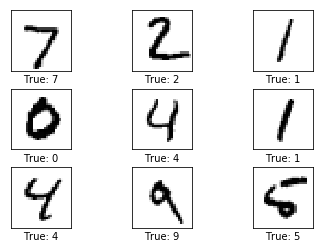

In [9]:
# 从测试数据集中取出前9个图片
images = data.test.images[0:9]

# 从测试数据集中取出前9个标签
cls_true = data.test.cls[0:9]

# 使用辅助函数将图片和标签画出来
plot_images(images=images, cls_true=cls_true)

### 占位符(Placeholder)变量

我们通过操作符号变量来描述交互的操作单元，x不是一个特定的值，而是一个占位符placeholder，我们在TensorFlow运行计算时输入这个值。x就被称作张量(tensor)，x可以表示为多维度的vector或者矩阵。我们希望能够输入任意数量的MNIST图像，每一张图展平成28x28维的向量。我们用2维的浮点数张量来表示这些图，该张量的数据类型被设置为`float32`，这个张量的形状是`[None，28x28]`。（这里的`None`表示此张量的第一个维度可以是任何长度的。）

In [10]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

然后我们使用占位符变量表示图片对应的标签，这个占位符变量的形状是`[None, num_classes]`，这表示该变量可以存储任意数量的标签，并且每个标签都是一个长度为`num_classes`也就是10的vector

In [11]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

最后我们定义一个保存标签对应的数字的占位符变量，我们之前提到过为了方便比较我们把标签都转换为单个数字，所以下面定义的这个变量就是存储这些数字。`[None]` 表示这个变量是一个一维任意长度的vector

In [12]:
y_true_cls = tf.placeholder(tf.int64, [None])

我们的模型也需要权重值和偏置量，当然我们可以把它们当做是另外的输入（使用占位符），但TensorFlow有一个更好的方法来表示它们：Variable 。 一个Variable代表一个可修改的张量，存在在TensorFlow的用于描述交互性操作的图中。它们可以用于计算输入值，也可以在计算中被修改。对于各种机器学习应用，一般都会有模型参数，可以用Variable表示。

我们赋予tf.Variable不同的初值来创建不同的Variable：在这里，我们都用全为零的张量来初始化weights和biases。因为我们要学习weights和biases的值，它们的初值可以随意设置。

注意，weights的形状是`[28x28，10]`，因为我们想要用28x28维的图片向量乘以它以得到一个10维的向量，每一位对应不同数字类。biases的形状是[10]，所以我们可以直接把它加到输出上面。

In [13]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

### 模型

这个简单的数学模型就是把占位符变量`x`保存的图片vector和变量`weights`相乘，然后再加上`biases`变量。

这样计算的结果是一个形状为`[num_images, num_classes]`的矩阵，因为`x`的形状是`[num_images, img_size_flat]`并且`weights`的形状是`[img_size_flat, num_classes]`，所以这两个变量的乘积是一个拥有`[num_images, num_classes]`形状的矩阵，再把`biases` vector加到矩阵中的每一行。

In [14]:
logits = tf.matmul(x, weights) + biases

但是因为预测值可能很小或者很大，所以很难去分析这些预测值，因此我们希望能够归一化这些预测值，使得`logits`矩阵的每一行加起来等于1并且每个元素都限制在0和1之间，这就是softmax函数的作用，得到的结果存在`y_pred`变量里面。

为了将预测值表示为单个数字，我们使用tf.argmax函数，把`y_pred`矩阵中每一行的最大值的坐标取出，也就获得了预测的标签值。

In [15]:
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, 1)

现在`logits`就是一个有`num_images`行和`num_classes`列的矩阵，第i行的第j列的数据表示的是模型估计出的第i个输入图片的标签是第j个类别的概率，也就是说第i个图片上的手写数字是j的概率。

为了能够使得我们建立的模型能够更准确的识别输入的图片，我们必须调整`weights`和`biases`变量。在机器学习中，我们通常定义指标来表示一个模型是坏的，这个指标称为成本（cost）或损失（loss），然后尽量最小化这个指标。但是，这两种方式是相同的。

一个非常常见的成本函数是“交叉熵”（cross-entropy）。交叉熵产生于信息论里面的信息压缩编码技术，但是它后来演变成为从博弈论到机器学习等其他领域里的重要技术手段。TensorFlow提供了一个计算交叉熵的内部函数，直接输入`logits`变量和保存图片对应的正确标签`y_true`变量。

In [16]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

现在我们已经对于每个图片分类进行了交叉熵的计算，所以我们可以得到我们的模型对于每个图片的预测表现。但是对于所有数据点的预测表现比单一数据点的表现能更好地描述我们的模型的性能，所以我们简单地将所有预测表现取平均值。

In [17]:
cost = tf.reduce_mean(cross_entropy)

### 优化方法

现在我们已经可以表示出模型的成本，为了能够最小化这个指标我们需要建立一个优化函数，本教程使用一个基本的梯度下降算法，以0.5的学习速率最小化交叉熵。

需要注意的是，我们定义的优化函数没有运行，事实上所有的语句都没有执行，我们只是把他们添加到TensorFlow工作图当中，在之后的语句中我们会让所有语句开始执行。

In [18]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### 性能评估

首先让我们找出那些预测正确的标签。y_pred_cls代表对于任一输入图片预测到的标签值，而y_true_cls代表图片对应正确的标签，我们可以用 tf.equal 来检测我们的预测是否真实标签匹配(索引位置一样表示匹配)。

In [19]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

correct_prediction是一组布尔值。为了确定正确预测项的比例，我们可以把布尔值转换成浮点数，然后取平均值。例如，[True, False, True, True] 会变成 [1,0,1,1] ，取平均值后得到 0.75.

In [20]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow运行

### 创建 TensorFlow session

当TensorFlow工作图创建完成，我们需要创建一个session来执行这个图。

In [21]:
session = tf.Session()

### 初始化变量

变量`weights`和`biases`需要在我们优化他们之前被初始化。

In [22]:
session.run(tf.global_variables_initializer())

### 执行优化迭代的函数

训练集中一共有50000张图片，在理想情况下，我们希望用我们所有的数据来进行每一步的训练，因为这能给我们更好的训练结果，但显然这需要很大的计算开销，因此我们使用一小部分的随机数据来进行训练，这又被称为随机训练（stochastic training）- 在这里更确切的说是随机梯度下降训练。所以，每一次训练我们可以使用不同的数据子集，这样做既可以减少计算开销，又可以最大化地学习到数据集的总体特性。

In [23]:
batch_size = 100

在循环的每个步骤中，我们都会随机抓取训练数据中的100个批处理数据点，然后我们用这些数据点作为参数替换之前的占位符来进行训练。

In [24]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # 获取100个训练样本作为批处理数据
        # x_batch保存的是一批图片数据
        # y_true_batch表示这些图片对应的正确标签数据
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # 将批处理数据放入字典(dict)中，字典中key的名字要与之前定义的占位符变量对应
        # 占位符变量y_true_cls因为在训练中没有用到所以暂时不定义
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # 使用这些批处理数据作为训练数据，然后运行优化函数
        # TensorFlow会把feed_dict_train中的变量赋值给对应的占位符变量，然后运行优化函数
        session.run(optimizer, feed_dict=feed_dict_train)

### 展示性能的函数

首先将测试数据放入到字典中和之前提到的训练字典一样，字典中key的名字要与之前定义的占位符变量对应

In [25]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

打印测试数据集预测准确性的函数

In [26]:
def print_accuracy():
    # 使用TensorFlow计算accuracy
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # 打印accuracy
    print("Accuracy on test-set: {0:.1%}".format(acc))

展示测试数据集中被错误识别的图片的函数

In [27]:
def plot_example_errors():
    # 使用TensorFlow获得表示每个测试图片是否被正确识别的boolean值列表
    # 和每个图片对应的预测值列表
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # 将boolean值列表取反
    incorrect = (correct == False)
    
    # 获得测试数据集中未被正确识别的图片
    images = data.test.images[incorrect]
    
    # 获取这些图片的的预测值
    cls_pred = cls_pred[incorrect]

    # 获取这些图片对应的正确类别值
    cls_true = data.test.cls[incorrect]
    
    # 画出前九个图片
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### 画出模型权重值的函数

画出模型权重值的函数，一共画出10个图片，每个图片代表模型识别的一个数字。

In [28]:
def plot_weights():
    # 从TensorFlow变量中获得权重值.
    w = session.run(weights)
    
    # 获得所有权重值中最小和最大的值，这两个值用来改变图片上颜色的密度，从而使得图片直接可以进行比较
    w_min = np.min(w)
    w_max = np.max(w)

    # 建立一个包含3x4个子图的图形，最后两个子图没有被使用，因为一共只有10个数字
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # 只使用前10个子图的权重值
        if i<10:
            # 取得第i个数字的权重值并且改变这个张量的形状，注意w的形状是img_size_flat x 10
            image = w[:, i].reshape(img_shape)

            # 为每个子图设置标签
            ax.set_xlabel("Weights: {0}".format(i))

            # 画图
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # 将轴线从每个子图中删除
        ax.set_xticks([])
        ax.set_yticks([])

## 优化前后的性能

测试数据集的准确性只有`9.8%`，这是因为模型只进行了初始化但是没有优化，所以模型对于图片的预测值都是0，这意味着10次预测有1次是正确的，这和展示的例子相符。

In [29]:
print_accuracy()

Accuracy on test-set: 9.8%


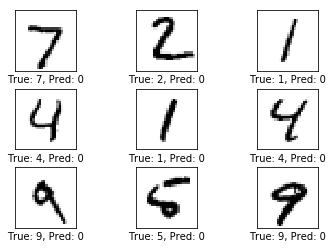

In [30]:
plot_example_errors()

## 1次优化迭代后的性能

完成一次优化迭代后，模型的准确性从`9.8%`提升到`37.0%`。

In [31]:
optimize(num_iterations=1)

In [32]:
print_accuracy()

Accuracy on test-set: 37.0%


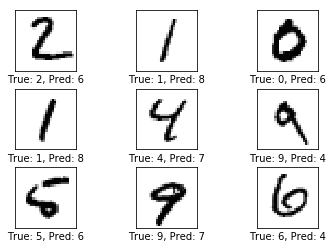

In [33]:
plot_example_errors()

下面画出每个数字的权重值，正权重是红色，负权重是蓝色，这些权重值可以进行图片的筛选。

例如，被用来判断一个图片是否是数字0的权重值中，圆圈图形对应的是正反馈(也就是红色)，但是对于圆圈中心的内容是负反馈(也就是蓝色)。类似地，被用来判断一个图片是否是数字1的权重值中，图像中心的垂线是正反馈(也就是红色)，但是直线周围的内容是负反馈(也就是蓝色)。

可以观察到，权重值的图形很像他们预计识别出的数字的形状，这是因为我们只使用了100张图片进行了一次优化迭代，当使用了几千张图片进行训练之后，权重值的图形很难被人理解，因为他们必须识别出同一个数字因为不同人进行书写所带来的差异。

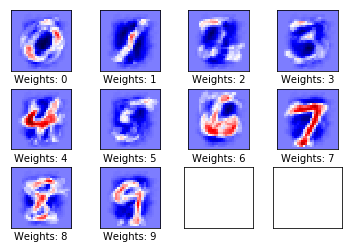

In [34]:
plot_weights()

## 10次优化迭代后的性能

In [35]:
# 因为已经进行了一次迭代
optimize(num_iterations=9)

In [36]:
print_accuracy()

Accuracy on test-set: 79.4%


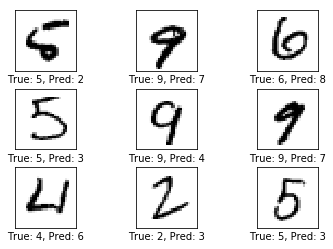

In [37]:
plot_example_errors()

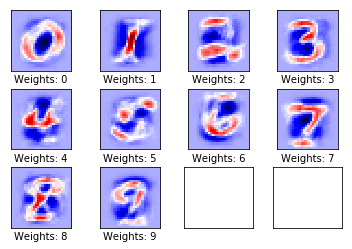

In [38]:
plot_weights()

## 1000次优化迭代后的性能

在进行了1000次优化迭代后，建立的模型对于10张图片只会识别错1张图片，就像画出的图展示的那样。有一些错误识别的图片是合理的，因为有些图片让人来识别也很难判断出对应什么数字。但是我们仍然可以通过使用更好的模型来提高准确性，教程中创建的简单模型很难达到更好的性能。

In [39]:
# 已经进行了10次迭代
optimize(num_iterations=990)

In [40]:
print_accuracy()

Accuracy on test-set: 91.7%


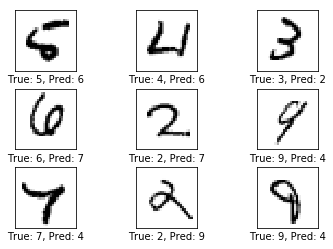

In [41]:
plot_example_errors()

模型已经进行了1000次优化迭代，每一次迭代都是使用100张训练数据集中的图片进行训练。因为代表同一个数字的图片之间差异很大，权重值现在已经很难被我们理解。

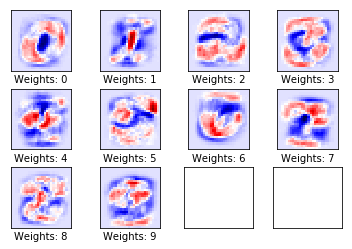

In [42]:
plot_weights()